# Experimental data assessment and model parameters optimisation

### Data preparation

The first step to generate three-dimensional (3D) models of a specific genomic regions is to filter columns with low counts and with no diagonal count in order to remove outliers or problematic columns from the interaction matrix. The particles associated with the filtered columns will be modelled, but will have no experimental data applied.

Here we load the data previous data already normalised.


In [1]:
from pytadbit import load_chromosome
from pytadbit.parsers.hic_parser import load_hic_data_from_bam

In [2]:
crm = load_chromosome('results/fragment/chr3.tdb')

In [3]:
B, PSC = crm.experiments

In [4]:
B, PSC

(Experiment mouse_B (resolution: 100 kb, TADs: 96, Hi-C rows: 1601, normalized: None),
 Experiment mouse_PSC (resolution: 100 kb, TADs: 118, Hi-C rows: 1601, normalized: None))

Load raw data matrices, and normalized matrices

In [5]:
base_path = 'results/fragment/{0}_both/03_filtering/valid_reads12_{0}.bam'
bias_path = 'results/fragment/{0}_both/04_normalizing/biases_{0}_both_{1}kb.biases'
reso = 100000
chrname = 'chr3'
cel1 = 'mouse_B'
cel2 = 'mouse_PSC'

In [6]:
hic_data1 = load_hic_data_from_bam(base_path.format(cel1),
                                   resolution=reso,
                                   region='chr3',
                                   biases=bias_path.format(cel1, reso // 1000),
                                   ncpus=8)
hic_data2 = load_hic_data_from_bam(base_path.format(cel2),
                                   resolution=reso,
                                   region='chr3',
                                   biases=bias_path.format(cel2, reso // 1000),
                                   ncpus=8)


  (Matrix size 1601x1601)                                                      [2020-02-06 16:39:39]

  - Parsing BAM (101 chunks)                                                   [2020-02-06 16:39:39]
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .                                                         101/101

  - Getting matrices                                                           [2020-02-06 16:39:42]
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .                                                         101/101


  (Matrix size 1601x1601)                                                      [2020-02-06 16:39:46]

  - Parsing BAM (101 chunks)                                                   [2020-02-06 16:39:46]
     .......... .......... .......... .......... ..........    

In [7]:
B.load_hic_data([hic_data1.get_matrix(focus='chr3')])
B.load_norm_data([hic_data1.get_matrix(focus='chr3', normalized=True)])

PSC.load_hic_data([hic_data2.get_matrix(focus='chr3')])
PSC.load_norm_data([hic_data2.get_matrix(focus='chr3', normalized=True)])

It is a good practice to check that the data is there:

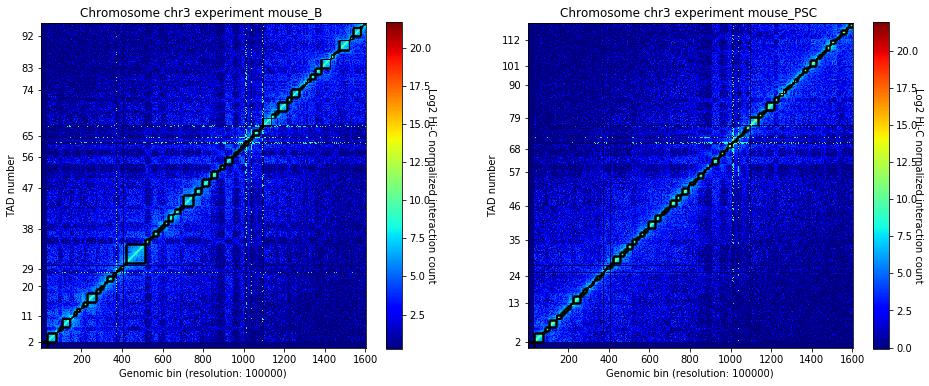

In [8]:
crm.visualize(['mouse_B', 'mouse_PSC'], normalized=True, paint_tads=True)

Focus on the genomic region to model.

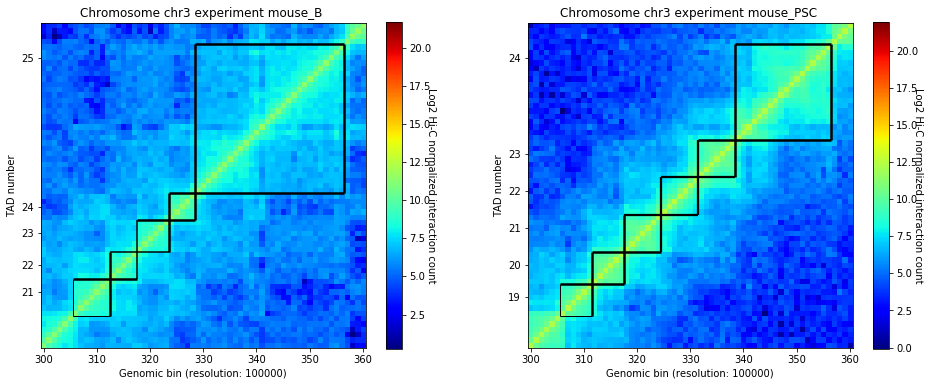

In [9]:
crm.visualize(['mouse_B', 'mouse_PSC'], normalized=True, paint_tads=True, focus=(300, 360))

### Data modellability assessment  via MMP score

We can use the Matrix Modeling Potential (MMP) score ([Trussart M. et al. Nature Communication, 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4402535/)) to identify a priori whether the interaction matrices have the potential of being use for modeling. The MMP score ranges from 0 to 1 and combines three different measures: the contribution of the significant eigenvectors, the skewness and the kurtosis of the distribution of Z-scores.

In [10]:
from pytadbit.utils.three_dim_stats import mmp_score

In [11]:
mmp_score(hic_data1.get_matrix(focus='chr3:30000000-36000000'),
          savefig='results/fragment/{0}_both/mmp_score.png'.format(cel1))

(0.8049308283731964,
 0.7885888244416531,
 0.6736346044021908,
 0.9006021702003049)

![](images/mmp_score.png)

### Data Transformation and scoring function

This  step is automatically done in TADbit. 
A a weight is generated for each pair of interactions proportional to their interaction count as in formula:
        
$$weight(I, J) = \frac{\sum^N_{i=0}{\sum^N_{j=0}{(matrix(i, j))}}}{\sum^N_{i=0}{(matrix(i, J))} \times \sum^N_{j=0}{(matrix(I, j))}}$$

The raw data are then multiplied by this weight. In the case that multiple experiments are used, the weighted interaction values are normalised using a factor  (default set as 1) in order to compare between experiments. 
Then, a Z-score of the off-diagonal normalised/weighted interaction is calculated as in formula:

$$zscore(I, J) = \frac{log_{10}(weight(I, J) \times matrix(I, J)) - mean(log_{10}(weight \times matrix))}{stddev(log_{10}(weight \times matrix))}$$

The Z-scores are then transformed to distance restraints. To define the type of restraints  between  each  pair  of  particles. we need to identified  empirically  three  optimal  parameters  (i) a maximal  distance  between  two  non-interacting  particles (maxdist), (ii) a lower-bound  cutoff  to  define  particles  that  do  not  interact  frequently (lowfreq) and (iii) an  upper-bound  cutoff  to  define  particles  that  do  interact  frequently (upfreq). In TADbit this is done via a grid  search  approach.


The following picture shows the different component of the scoring funtion that is optimised during the Monte Carlo  simulated annealing sampling protocol.
Two  consecutive particles are spatially restrained  by  a  harmonic  oscillator  with  an  equilibrium  distance  that  corresponds to  the sum of their radii. Non-consecutive  particles  with  contact  frequencies  above  the  upper-bound  cutoff are restrained by a harmonic  oscillator  at  an  equilibrium  distance,  while  those  below  the  lower-bound  cutoff are maintained further than  an  equilibrium  distance  by  a  lower  bound  harmonic  oscillator.   

![](images/tadbit_restraints.png)


## Optimization of parameters

We need to identified empirically (via a grid-search optimisation) the optimal parameters for the mdoelling procedure:

 - maxdist: maximal distance assosiated two interacting particles.
 - upfreq: to define particles that do interact frequently (defines attraction)
 - lowfreq: to define particles that do not interact frequently ( defines repulsion)
 - dcutoff: the definition of "contact" in units of bead diameter. Value of 2 means that a contact will occur when 2 
    beads are closer than 2 times their diameter. This will be used to compare 3D models with Hi-C interaction maps.
 
 
Pairs of beads interacting less than lowfreq (left dashed line) are penalized if they are closer than their assigned minimum distance (Harmonic lower bound). 
Pairs of beads interacting more than ufreq (right dashed line) are penalized if they are further apart than their assigned maximum distance (Harmonic upper bound).
Pairs of beads which interaction fall in between lowfreq and upfreq are not penalized except if they are neighbours (Harmonic)


![](images/tadbit_distance_freq_fitting.png)


In the parameter optimization step we are going to give a set of ranges for the different search parameters. For each possible combination TADbit will produce a set of models. 

In each individual model we consider that two beads are in contact if their distance in 3D space is lower than the specified distance cutoff. TADbit builds a cumulative contact map for each set of models as shown in the schema below. The contact map is then compared with the Hi-C interaction experiment by means of a Spearman correlation coefficient. The sets having higher correlation coefficients are those that best represents the original data.

![](images/Contact_map.png)

In [12]:
opt_B = B.optimal_imp_parameters(start=300, end=360, n_models=40, n_keep=20, n_cpus=8, 
                                   upfreq_range=(0, 0.6, 0.3),
                                   lowfreq_range=(-0.9, 0, 0.3),
                                   maxdist_range=(1000, 2000, 500), 
                                   dcutoff_range=[2, 3, 4])

Optimizing 61 particles
  num scale	kbending	maxdist	lowfreq	upfreq	dcutoff	correlation


  1   0.01 	0       	1000   	-0.9   	0     	4      0.2021
  1   0.01 	0       	1000   	-0.9   	0     	3      0.5706
  1   0.01 	0       	1000   	-0.9   	0     	2      0.8769
  2   0.01 	0       	1000   	-0.9   	0.3   	4      0.3995
  2   0.01 	0       	1000   	-0.9   	0.3   	3      0.6799
  2   0.01 	0       	1000   	-0.9   	0.3   	2      0.8864
  3   0.01 	0       	1000   	-0.9   	0.6   	4      0.62
  3   0.01 	0       	1000   	-0.9   	0.6   	3      0.7709
  3   0.01 	0       	1000   	-0.9   	0.6   	2      0.8531
  4   0.01 	0       	1000   	-0.6   	0     	4      0.205
  4   0.01 	0       	1000   	-0.6   	0     	3      0.58
  4   0.01 	0       	1000   	-0.6   	0     	2      0.8773
  5   0.01 	0       	1000   	-0.6   	0.3   	4      0.4014
  5   0.01 	0       	1000   	-0.6   	0.3   	3      0.6827
  5   0.01 	0       	1000   	-0.6   	0.3   	2      0.8869
  6   0.01 	0       	1000   	-0.6   	0.6   	4      0.6181
  6   0.01 	0       	1000   	-0.6   	0.6   	3      0.776
  6   0.01 	0       

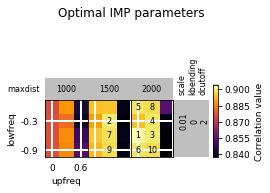

In [13]:
opt_B.plot_2d(show_best=10)

Refine optimization in a small region:

In [14]:
opt_B.run_grid_search(upfreq_range=(0, 0.3, 0.3), lowfreq_range=(-0.9, -0.3, 0.3),
                       maxdist_range=[1750], 
                       dcutoff_range=[2, 3],
                       n_cpus=8)

Optimizing 61 particles
  num scale	kbending	maxdist	lowfreq	upfreq	dcutoff	correlation


  1   0.01 	0       	1750   	-0.9   	0     	3      0.6859
  1   0.01 	0       	1750   	-0.9   	0     	2      0.8985
  2   0.01 	0       	1750   	-0.9   	0.3   	3      0.7587
  2   0.01 	0       	1750   	-0.9   	0.3   	2      0.9
  3   0.01 	0       	1750   	-0.6   	0     	3      0.6879
  3   0.01 	0       	1750   	-0.6   	0     	2      0.8937
  4   0.01 	0       	1750   	-0.6   	0.3   	3      0.7521
  4   0.01 	0       	1750   	-0.6   	0.3   	2      0.8993
  5   0.01 	0       	1750   	-0.3   	0     	3      0.6857
  5   0.01 	0       	1750   	-0.3   	0     	2      0.9
  6   0.01 	0       	1750   	-0.3   	0.3   	3      0.7644
  6   0.01 	0       	1750   	-0.3   	0.3   	2      0.8981


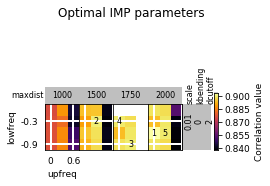

In [15]:
opt_B.plot_2d(show_best=5)

In [16]:
opt_B.run_grid_search(upfreq_range=(0, 0.3, 0.3), lowfreq_range=(-0.3, 0, 0.1),
                       maxdist_range=[2000, 2250], 
                       dcutoff_range=[2],
                       n_cpus=8)

  xx   	0.01 	0       	2000   	-0.3   	0     	4.0    	0.4678
  xx   	0.01 	0       	2000   	-0.3   	0.3   	4.0    	0.5525


Optimizing 61 particles
  num scale	kbending	maxdist	lowfreq	upfreq	dcutoff	correlation


  1   0.01 	0       	2000   	-0.2   	0     	2      0.9001
  2   0.01 	0       	2000   	-0.2   	0.3   	2      0.8989
  3   0.01 	0       	2000   	-0.1   	0     	2      0.901
  4   0.01 	0       	2000   	-0.1   	0.3   	2      0.8967
  xx   	0.01 	0       	2000   	0      	0     	4.0    	0.4594
  xx   	0.01 	0       	2000   	0      	0.3   	4.0    	0.5481
  5   0.01 	0       	2250   	-0.3   	0     	2      0.8962
  6   0.01 	0       	2250   	-0.3   	0.3   	2      0.8964
  7   0.01 	0       	2250   	-0.2   	0     	2      0.9024
  8   0.01 	0       	2250   	-0.2   	0.3   	2      0.9004
  9   0.01 	0       	2250   	-0.1   	0     	2      0.8992
  10  0.01 	0       	2250   	-0.1   	0.3   	2      0.9009
  11  0.01 	0       	2250   	0      	0     	2      0.9001
  12  0.01 	0       	2250   	0      	0.3   	2      0.8967


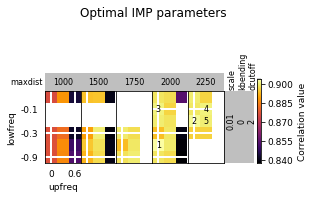

In [17]:
opt_B.plot_2d(show_best=5)

In [18]:
opt_B.run_grid_search(upfreq_range=(0, 0.3, 0.1), lowfreq_range=(-0.3, 0, 0.1),
                       n_cpus=8,
                       maxdist_range=[2000, 2250], 
                       dcutoff_range=[2])

  xx   	0.01 	0       	2000   	-0.3   	0     	4.0    	0.4678


Optimizing 61 particles
  num scale	kbending	maxdist	lowfreq	upfreq	dcutoff	correlation


  1   0.01 	0       	2000   	-0.3   	0.1   	2      0.898
  2   0.01 	0       	2000   	-0.3   	0.2   	2      0.8979
  xx   	0.01 	0       	2000   	-0.3   	0.3   	4.0    	0.5525
  xx   	0.01 	0       	2000   	-0.2   	0     	2.0    	0.9001
  3   0.01 	0       	2000   	-0.2   	0.1   	2      0.8908
  4   0.01 	0       	2000   	-0.2   	0.2   	2      0.8944
  xx   	0.01 	0       	2000   	-0.2   	0.3   	2.0    	0.8989
  xx   	0.01 	0       	2000   	-0.1   	0     	2.0    	0.901
  5   0.01 	0       	2000   	-0.1   	0.1   	2      0.8967
  6   0.01 	0       	2000   	-0.1   	0.2   	2      0.8941
  xx   	0.01 	0       	2000   	-0.1   	0.3   	2.0    	0.8967
  xx   	0.01 	0       	2000   	0      	0     	4.0    	0.4594
  7   0.01 	0       	2000   	0      	0.1   	2      0.9006
  8   0.01 	0       	2000   	0      	0.2   	2      0.8914
  xx   	0.01 	0       	2000   	0      	0.3   	4.0    	0.5481
  xx   	0.01 	0       	2250   	-0.3   	0     	2.0    	0.8962
  9   0.01 	0       	2250   	-0.3   	0.1   	2     

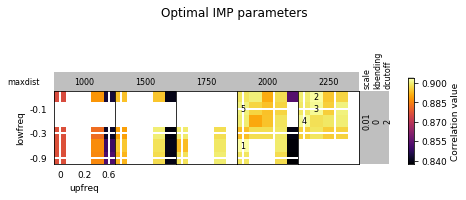

In [19]:
opt_B.plot_2d(show_best=5)

In [20]:
opt_B.get_best_parameters_dict()

{'scale': 0.01,
 'kbending': 0.0,
 'maxdist': 2000.0,
 'lowfreq': -0.6,
 'upfreq': 0.0,
 'dcutoff': 2.0,
 'reference': '',
 'kforce': 5}

For the other replicate, we can reduce the space of search:

In [21]:
opt_PSC = PSC.optimal_imp_parameters(start=300, end=360, n_models=40, n_keep=20, n_cpus=8, 
                                     upfreq_range=(0, 0.3, 0.1),
                                     lowfreq_range=(-0.3, -0.1, 0.1),
                                     maxdist_range=(2000, 2250, 250), 
                                     dcutoff_range=[2])

Optimizing 61 particles
  num scale	kbending	maxdist	lowfreq	upfreq	dcutoff	correlation


  1   0.01 	0       	2000   	-0.3   	0     	2      0.9309
  2   0.01 	0       	2000   	-0.3   	0.1   	2      0.9237
  3   0.01 	0       	2000   	-0.3   	0.2   	2      0.9177
  4   0.01 	0       	2000   	-0.3   	0.3   	2      0.9084
  5   0.01 	0       	2000   	-0.2   	0     	2      0.9268
  6   0.01 	0       	2000   	-0.2   	0.1   	2      0.9245
  7   0.01 	0       	2000   	-0.2   	0.2   	2      0.9159
  8   0.01 	0       	2000   	-0.2   	0.3   	2      0.9095
  9   0.01 	0       	2000   	-0.1   	0     	2      0.9283
  10  0.01 	0       	2000   	-0.1   	0.1   	2      0.9239
  11  0.01 	0       	2000   	-0.1   	0.2   	2      0.9136
  12  0.01 	0       	2000   	-0.1   	0.3   	2      0.9071
  13  0.01 	0       	2250   	-0.3   	0     	2      0.9285
  14  0.01 	0       	2250   	-0.3   	0.1   	2      0.9233
  15  0.01 	0       	2250   	-0.3   	0.2   	2      0.9165
  16  0.01 	0       	2250   	-0.3   	0.3   	2      0.9068
  17  0.01 	0       	2250   	-0.2   	0     	2      0.9294
  18  0.01 	0 

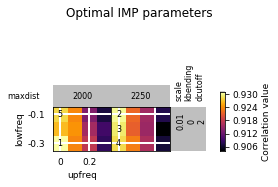

In [22]:
opt_PSC.plot_2d(show_best=5)

In [23]:
opt_PSC.get_best_parameters_dict()

{'scale': 0.01,
 'kbending': 0.0,
 'maxdist': 2000.0,
 'lowfreq': -0.3,
 'upfreq': 0.0,
 'dcutoff': 2.0,
 'reference': '',
 'kforce': 5}